# Install requirements

In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install requests

# Run setup

In [2]:
"""
To run this notebook in Google Colab, you need to the following first:
1. Open this link: https://drive.google.com/drive/folders/1adprVKMxSlXTn-S3ZAbOx545cxv5CzHl?usp=sharing
2. Then go to "Shared with me" in your Google Drive, right-click the "AIUK" folder
and select "Add shortcut to Drive"

Optionally, if you don't have a Google Drive account, you can set colab to False,
and download the data.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

colab = False

if colab:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive')
    root_dir = Path('/content/drive/MyDrive/AIUK')
else:
    from data import download_data
    download_data()
    root_dir = Path('./')

# Climate change indicators dataset

Anthropogenic climate change is one of the most important social issues facing humanity, and one in which big data can play a role in determining the most effective policy interventions. Today, we'll be taking a look at some of the key indicators of warming, including CO2 levels, glacier size, change in sea levels, and so on. We will also be making data available on some human factors involved, including impacts of fossil fuel burning per nation, and the fluctuating price of carbon credits.

Dataset source: https://datahub.io/collections/climate-change

## CO2

In the next few cells we'll explore the datasets. Let's first take a look at the dataset which gives us the average monthly concentration of CO2 at the Mauna Loa observatory, measured in parts per million (PPM).



In [3]:
co2_df = pd.read_csv(root_dir.joinpath('co2_monthly.csv'), parse_dates=['Date'])
co2_df.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
3,1958-06-01,1958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1


As you can see, we get the date in YYYY-MM-DD format, with a monthly average, as well as a seasonally-corrected trend. Number of days refers to the number of day readings averaged, -1 denoting that the monthly data is interpolated from other sources.

Let's plot the monthly average since 1990, and generate a best fit line showing the trend.

In [4]:
since_90 = co2_df[co2_df.Date>'1990']
date_num = dates.date2num(since_90.Date)
params = np.polyfit(date_num, since_90.Average, 1)
fit = np.poly1d(params)
x_fit = np.linspace(date_num.min(), date_num.max())

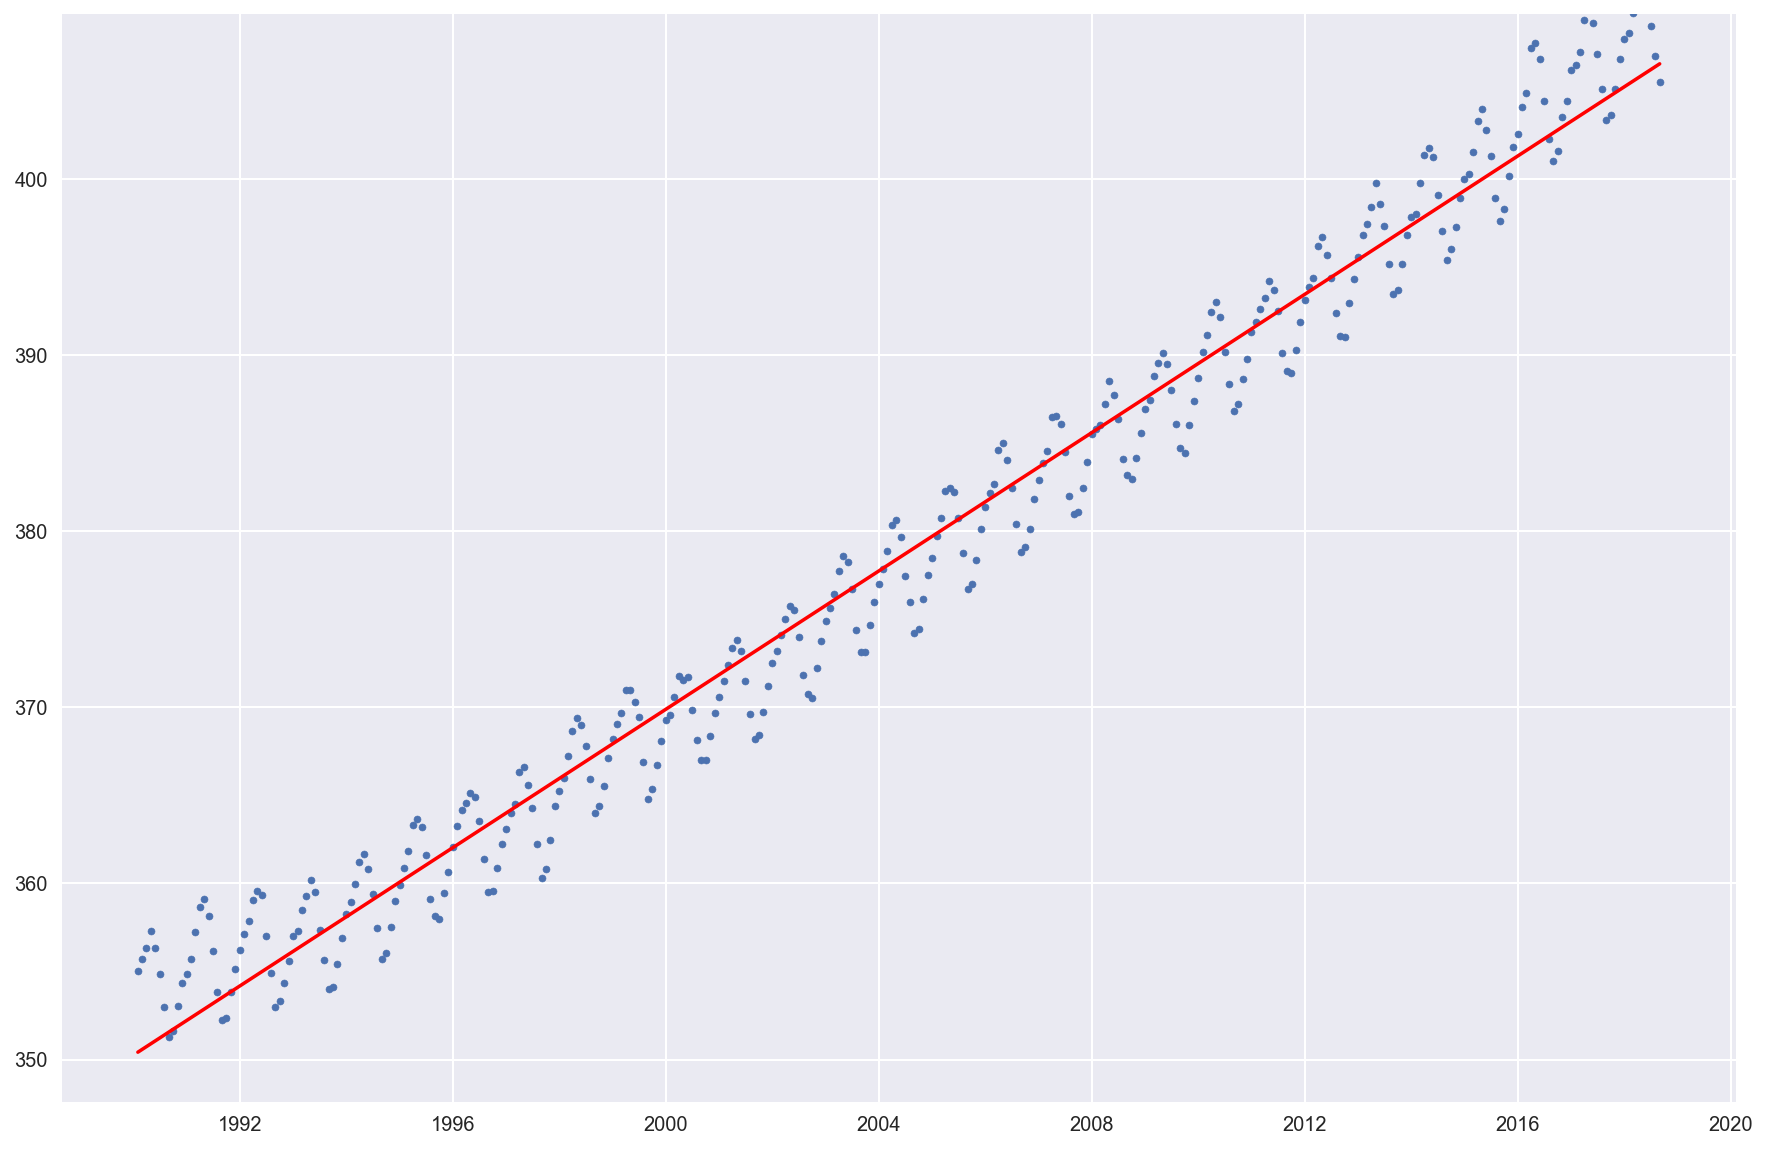

In [5]:
plt.scatter(pd.to_datetime(since_90.Date), since_90.Average, marker='.')
plt.plot(dates.num2date(x_fit), fit(x_fit), 'r')
plt.show()

## Temperature changes

What about the correlation between temperature change and CO2? Let's add our global anomalous temperatures dataset to our plot as well.

In [6]:
temp_df = pd.read_csv(root_dir.joinpath('temp_monthly.csv'), parse_dates=['Date'])
temp_df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [7]:
temp_since_90 = temp_df.loc[(temp_df.Date > '1990') & (temp_df.Source == 'GISTEMP')]

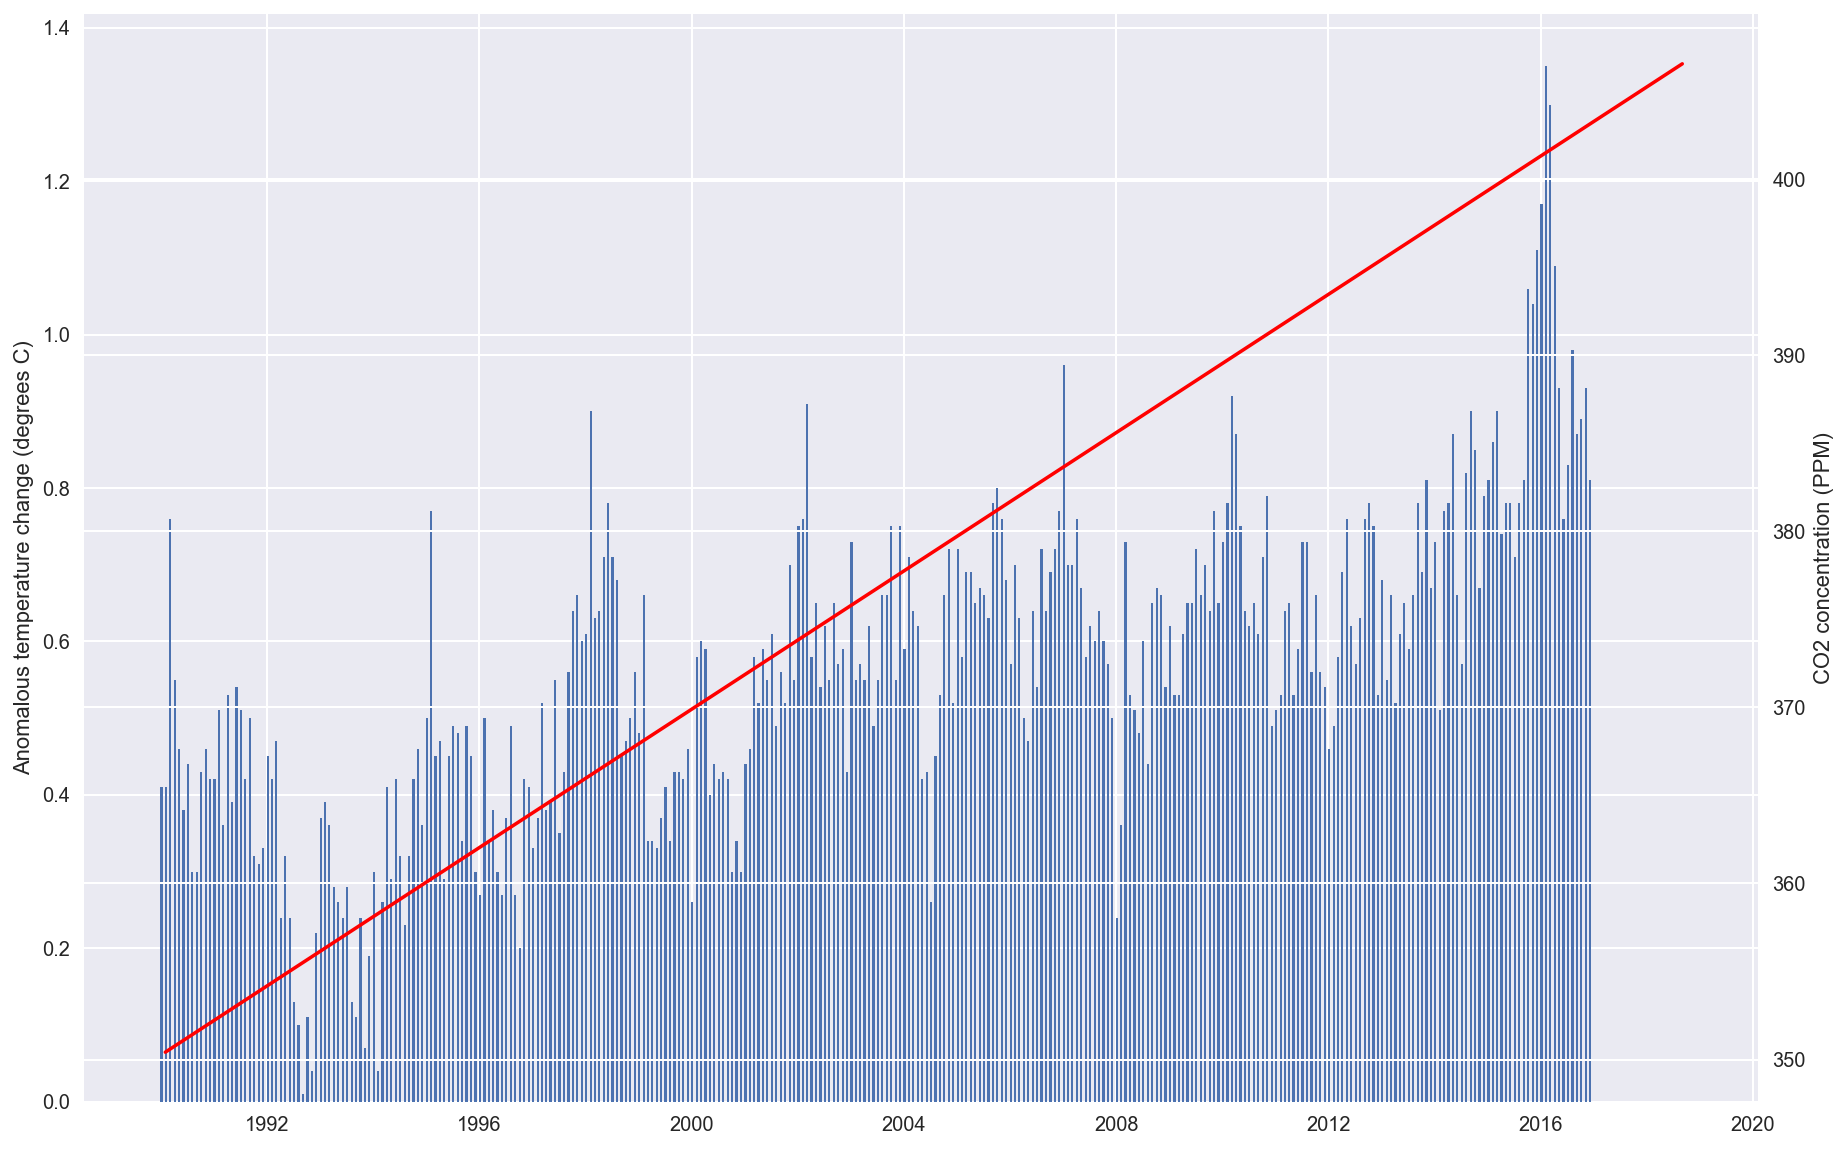

In [8]:
fig, ax = plt.subplots()
ax.bar(pd.to_datetime(temp_since_90.Date), temp_since_90.Mean, width=15.0)
ax.set_ylabel('Anomalous temperature change (degrees C)')

ax2 = ax.twinx()
ax2.set_ylabel('CO2 concentration (PPM)')

ax2.plot(dates.num2date(x_fit), fit(x_fit), 'r')
plt.show()

## Sea level

For millions of people around the world, the most immediate impact of climate change is sea level rise, which threatens not only homes and businesses, but also vast areas of agricultural land, as well as access to clean, desalinated water.

<img src="https://cloudfront-us-east-2.images.arcpublishing.com/reuters/3XK6LJVMXBMXZMBV45JCDUZN6Y.jpg">


Let's take a look at the sea level dataset.


In [9]:
s_df = pd.read_csv(root_dir.joinpath('sea_level.csv'), parse_dates=['Year'])
s_df.head()

,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound,NOAA Adjusted Sea Level
0,1880-03-15,0.000000,-0.952756,0.952756,NaN
1,1881-03-15,0.220472,-0.732283,1.173228,NaN
2,1882-03-15,-0.440945,-1.346457,0.464567,NaN
3,1883-03-15,-0.232283,-1.129921,0.665354,NaN
4,1884-03-15,0.590551,-0.283465,1.464567,NaN


This set provides two measurements of changes in the average sea level in inches per year since 1880, provided by the CSIRO (Commonwealth Scientific and Industrial Research Organization) and EPA (United States Environmental Protection Agency). We can see where these measurements overlap by plotting the trend of each since 1990.

In [10]:
s_since_90 = s_df[s_df.Year > '1990']

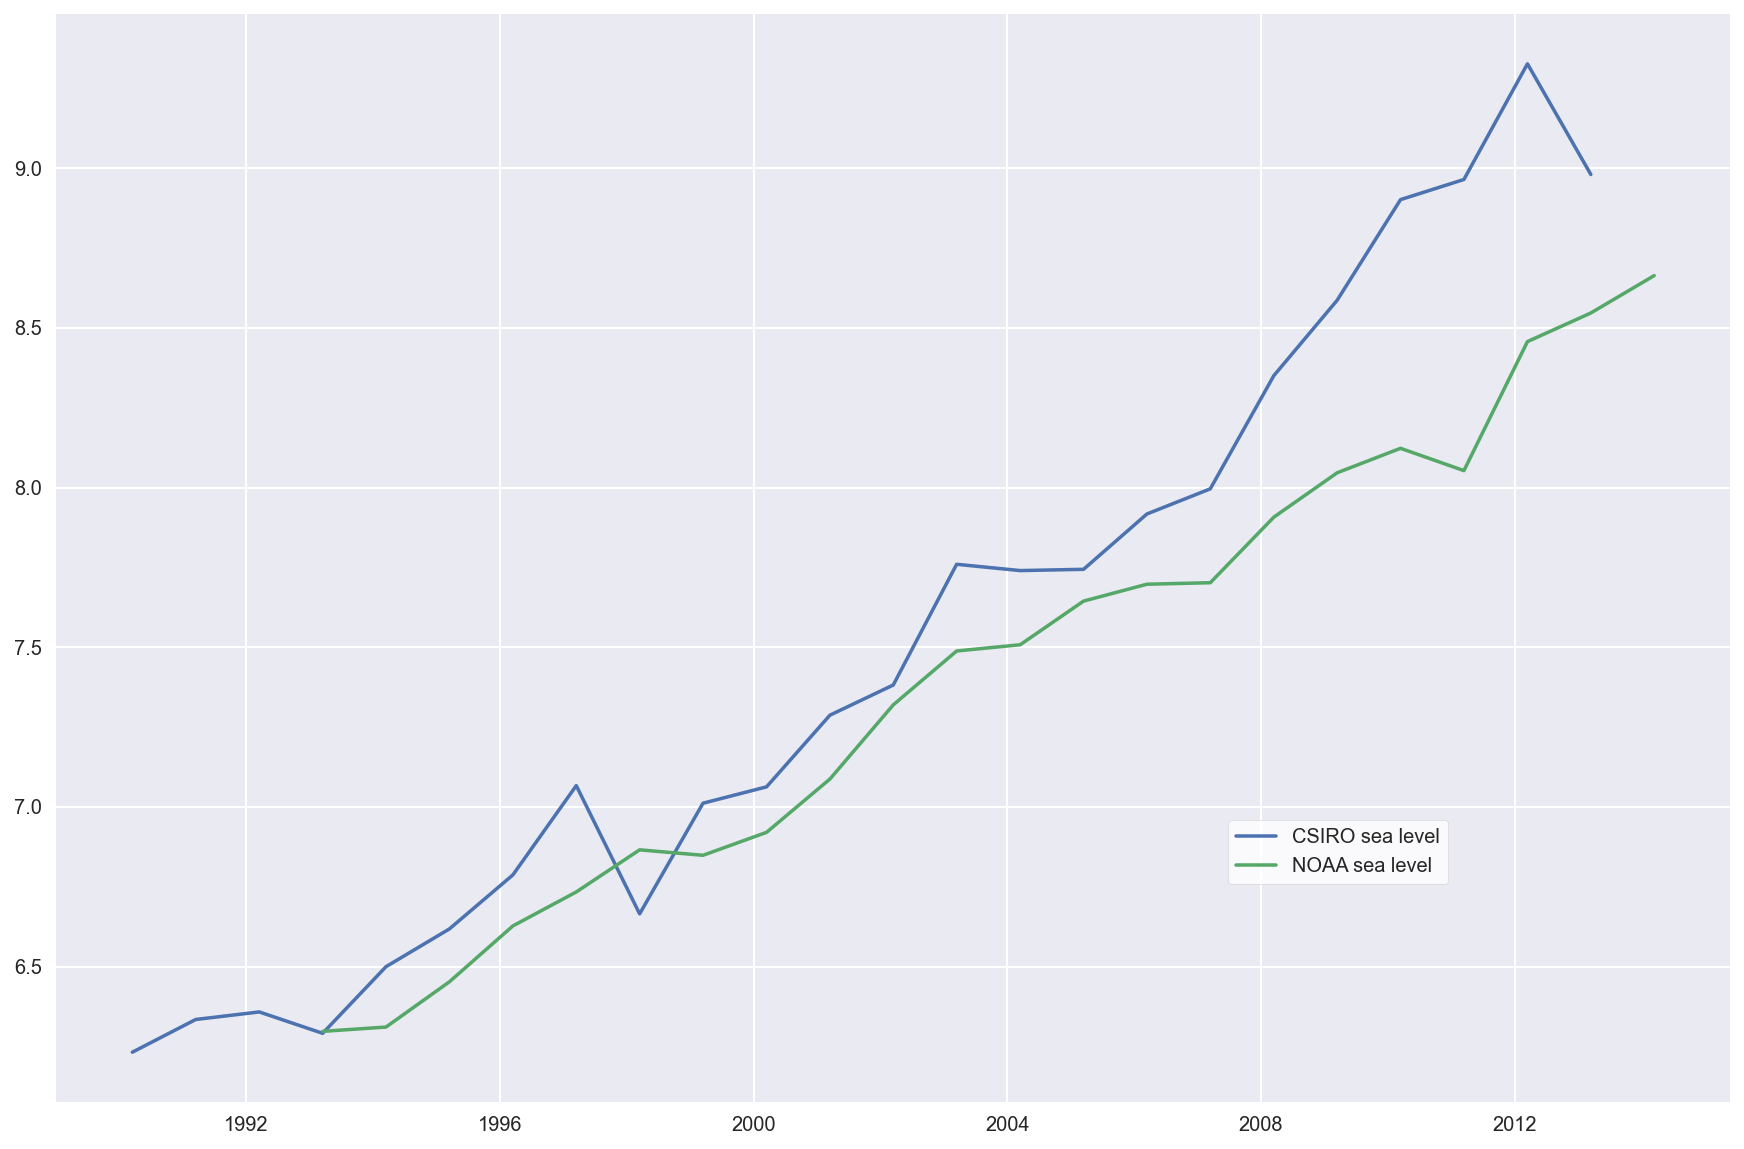

In [11]:
plt.plot(pd.to_datetime(s_since_90.Year), s_since_90['CSIRO Adjusted Sea Level'], label='CSIRO sea level')
plt.plot(pd.to_datetime(s_since_90.Year), s_since_90['NOAA Adjusted Sea Level'], label='NOAA sea level')
plt.legend(loc=(0.7, 0.2), frameon=True, facecolor='white')
plt.show()

## Predicting sea level rise

The rate of increase is somewhat linear, with ~9 inches higher average sea levels over the 1880 figure, but lets try to predict what the increase might look like over the next 30 years. To do that, we'll train a simple regression model.

We'll first collect our data and resample our time scale to the year.

In [12]:
s = s_df[['Year', 'CSIRO Adjusted Sea Level']].groupby(pd.Grouper(key='Year', axis=0, freq='Y')).mean().reset_index()
s.rename(columns = {'Year':'Date', 'CSIRO Adjusted Sea Level': 'Sea Level'}, inplace = True)
s = s[s.Date < '2014']
s.head()

,Date,Sea Level
0,1880-12-31,0.000000
1,1881-12-31,0.220472
2,1882-12-31,-0.440945
3,1883-12-31,-0.232283
4,1884-12-31,0.590551


Then, we'll train a linear regressor to predict our outcome (Sea Level) from the date. First, we'll split our available data into a training and test set, then train our regression with the labels from the training set. Then, we'll make some predictions on the test set, and see how well our model fits.

**NOTE**: this is obviously not a practical solution, given that the rate of sea level rises probably isn't solely determined by the calendar year, but multiple climate-related factors, but it will work as a simple demonstration of the principle.

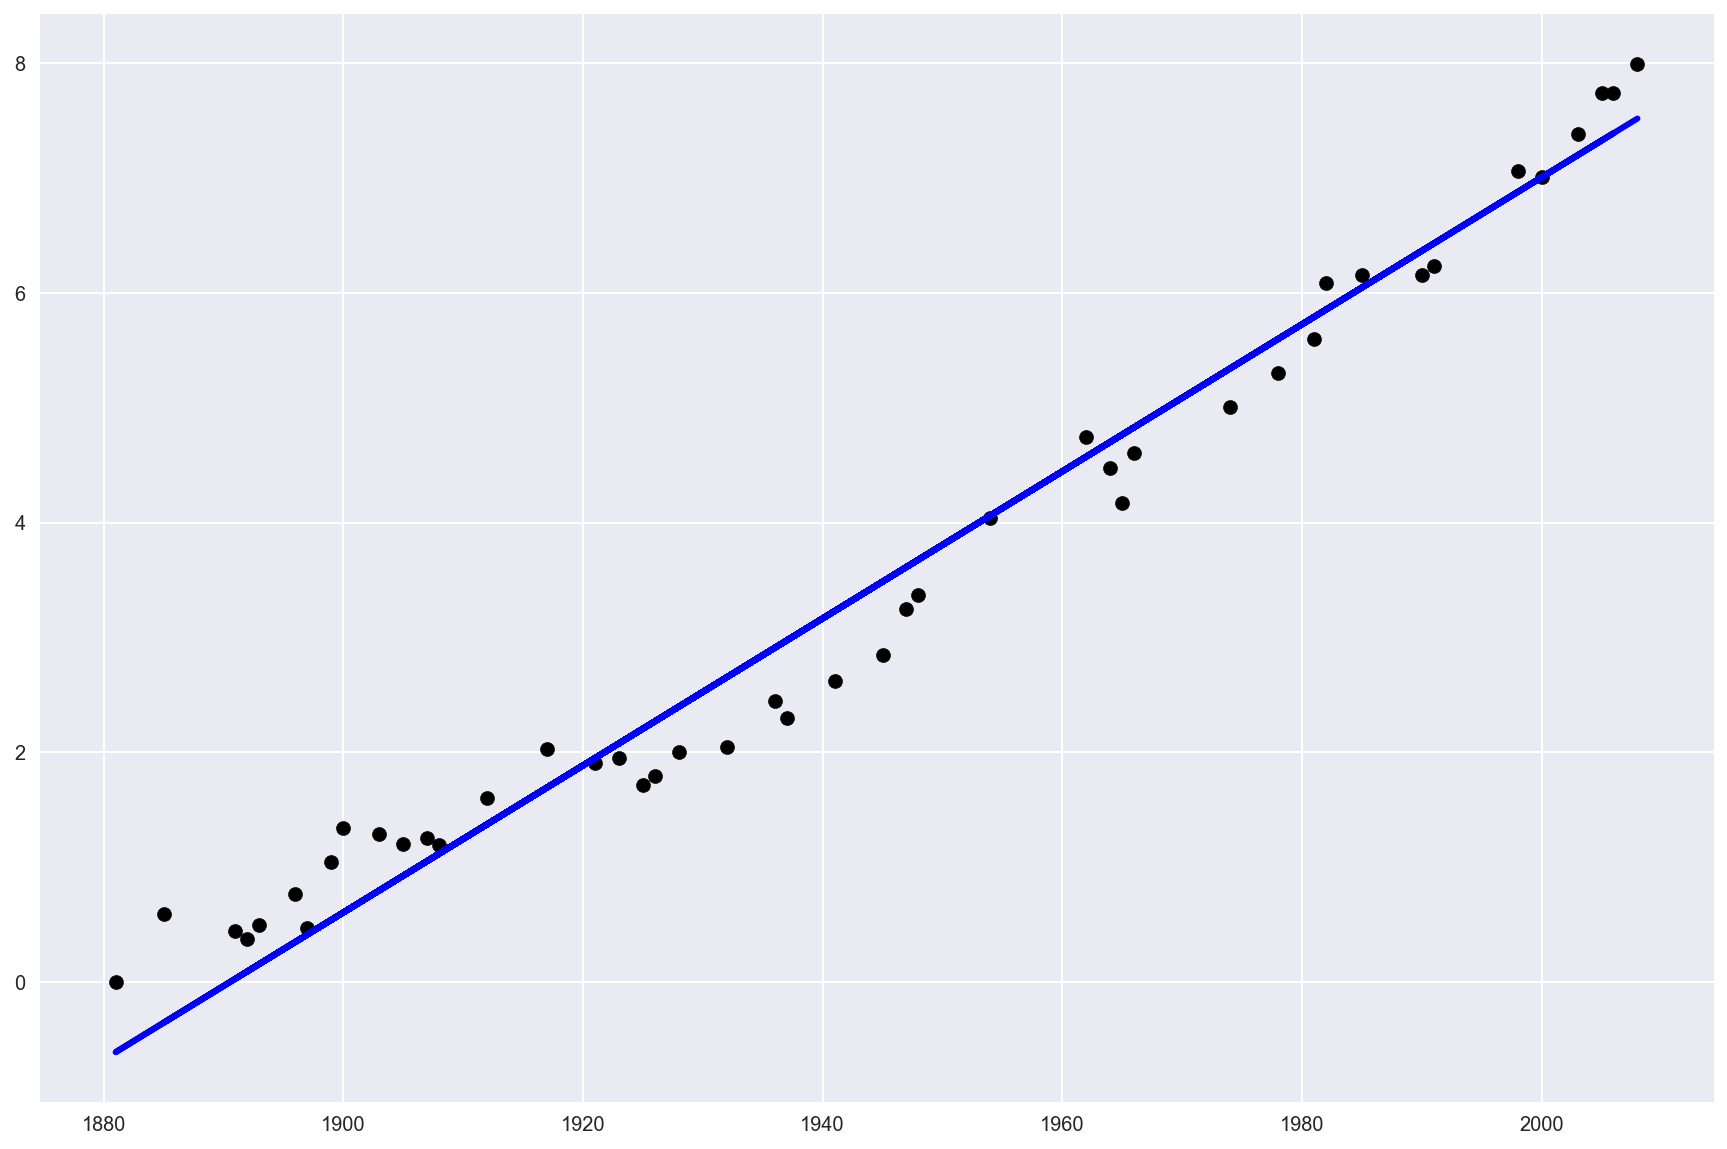

In [13]:
from sklearn import linear_model, model_selection
import datetime

X = np.array(s['Date'].apply(lambda x:x.toordinal())).reshape(-1, 1)
y = s['Sea Level']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

x_dt = [datetime.date.fromordinal(x[0]) for x in X_test]

plt.scatter(x_dt, y_test, color="black")
plt.plot(x_dt, y_pred, color="blue", linewidth=3)

plt.show()

The regression seems to fit quite well with the data that we've got so far, so let's make some predictions for the future.

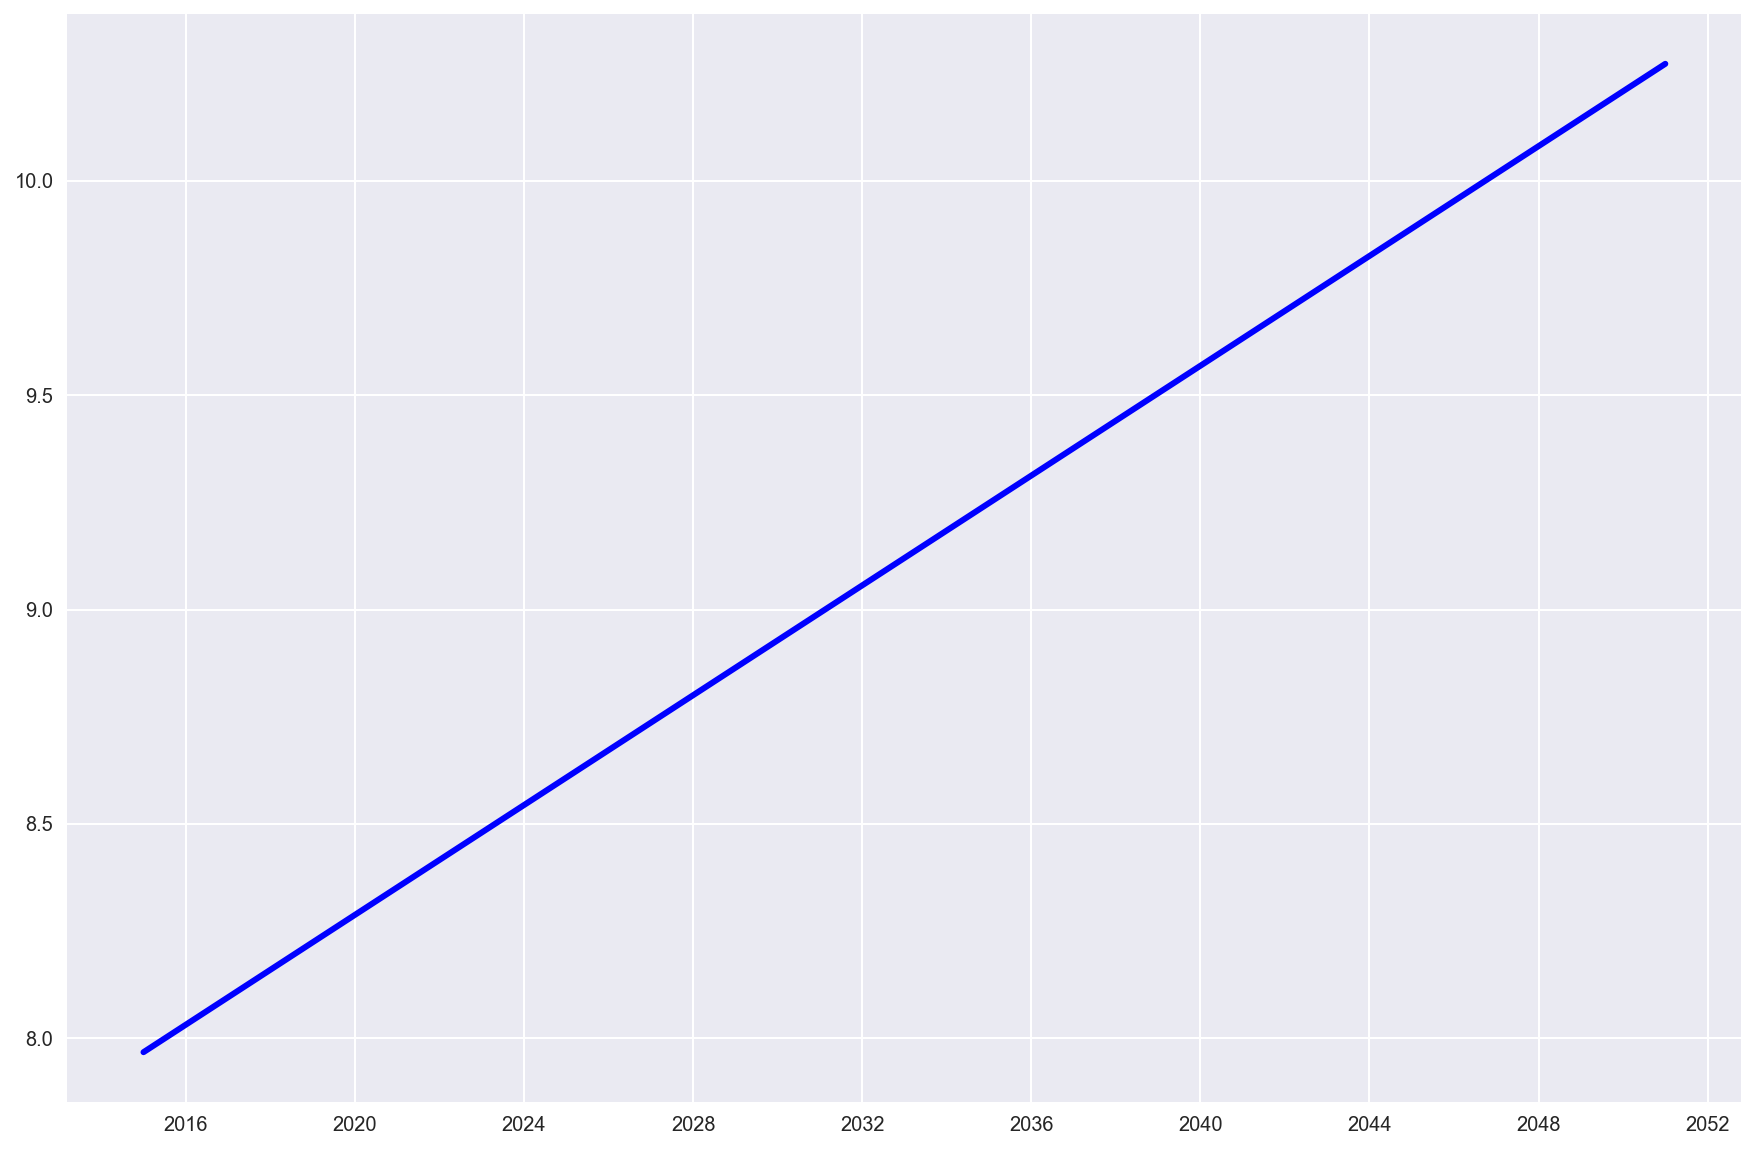

In [14]:
start = '2014-12-31'
end = '2050-12-31'

new_dates = pd.date_range(start, end, freq='1Y')
x_fut = np.array(new_dates.to_series().apply(lambda x:x.toordinal())).reshape(-1, 1)

y_pred = regressor.predict(x_fut)
fut_dt = [datetime.date.fromordinal(x[0]) for x in x_fut]

plt.plot(fut_dt, y_pred, color="blue", linewidth=3)

plt.show()

From this simple prediction, we can see that if the rate of increase stays stable, we can expect greater than 10 inches of sea level rise by 2050: [enough to put large parts of England, as well as virtually the entire Netherlands](https://coastal.climatecentral.org/map/8/1.1818/51.4022/?theme=sea_level_rise&map_type=year&basemap=roadmap&contiguous=true&elevation_model=best_available&forecast_year=2050&pathway=rcp45&percentile=p50&refresh=true&return_level=return_level_1&rl_model=gtsr&slr_model=kopp_2014), under water.

![London flooding](https://2.bp.blogspot.com/_Fv90J7eTcis/TFs8VbyP1fI/AAAAAAAAGKc/tF6rECNfLbE/s1600/Flood.jpg)

# Climate change sentiment dataset

Beyond the bare numbers, combating climate change will require buy-in from people in all walks of life. Part of persuading people about the need to combat the deadly outcomes of global warming is identifying which parts of the population are already persuaded, and what evidence each side is deploying to support their point of view.

We've provided a dataset includes a large group of social media posts related to climate change, annotated by human experts as referring to either factual news sources (2), or as opinion indicating that the person is promoting either belief or disbelief in anthropogenic warming (1 or -1). Messages without an obvious valence are marked with a 0.

You can find that dataset in your Google Drive at /content/drive/MyDrive/AIUK/cc_sentiment.csv

Dataset source: https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [15]:
data = pd.read_csv(root_dir.joinpath('cc_sentiment.csv'))
data.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Let's see how many examples of each class we have in our dataset. 

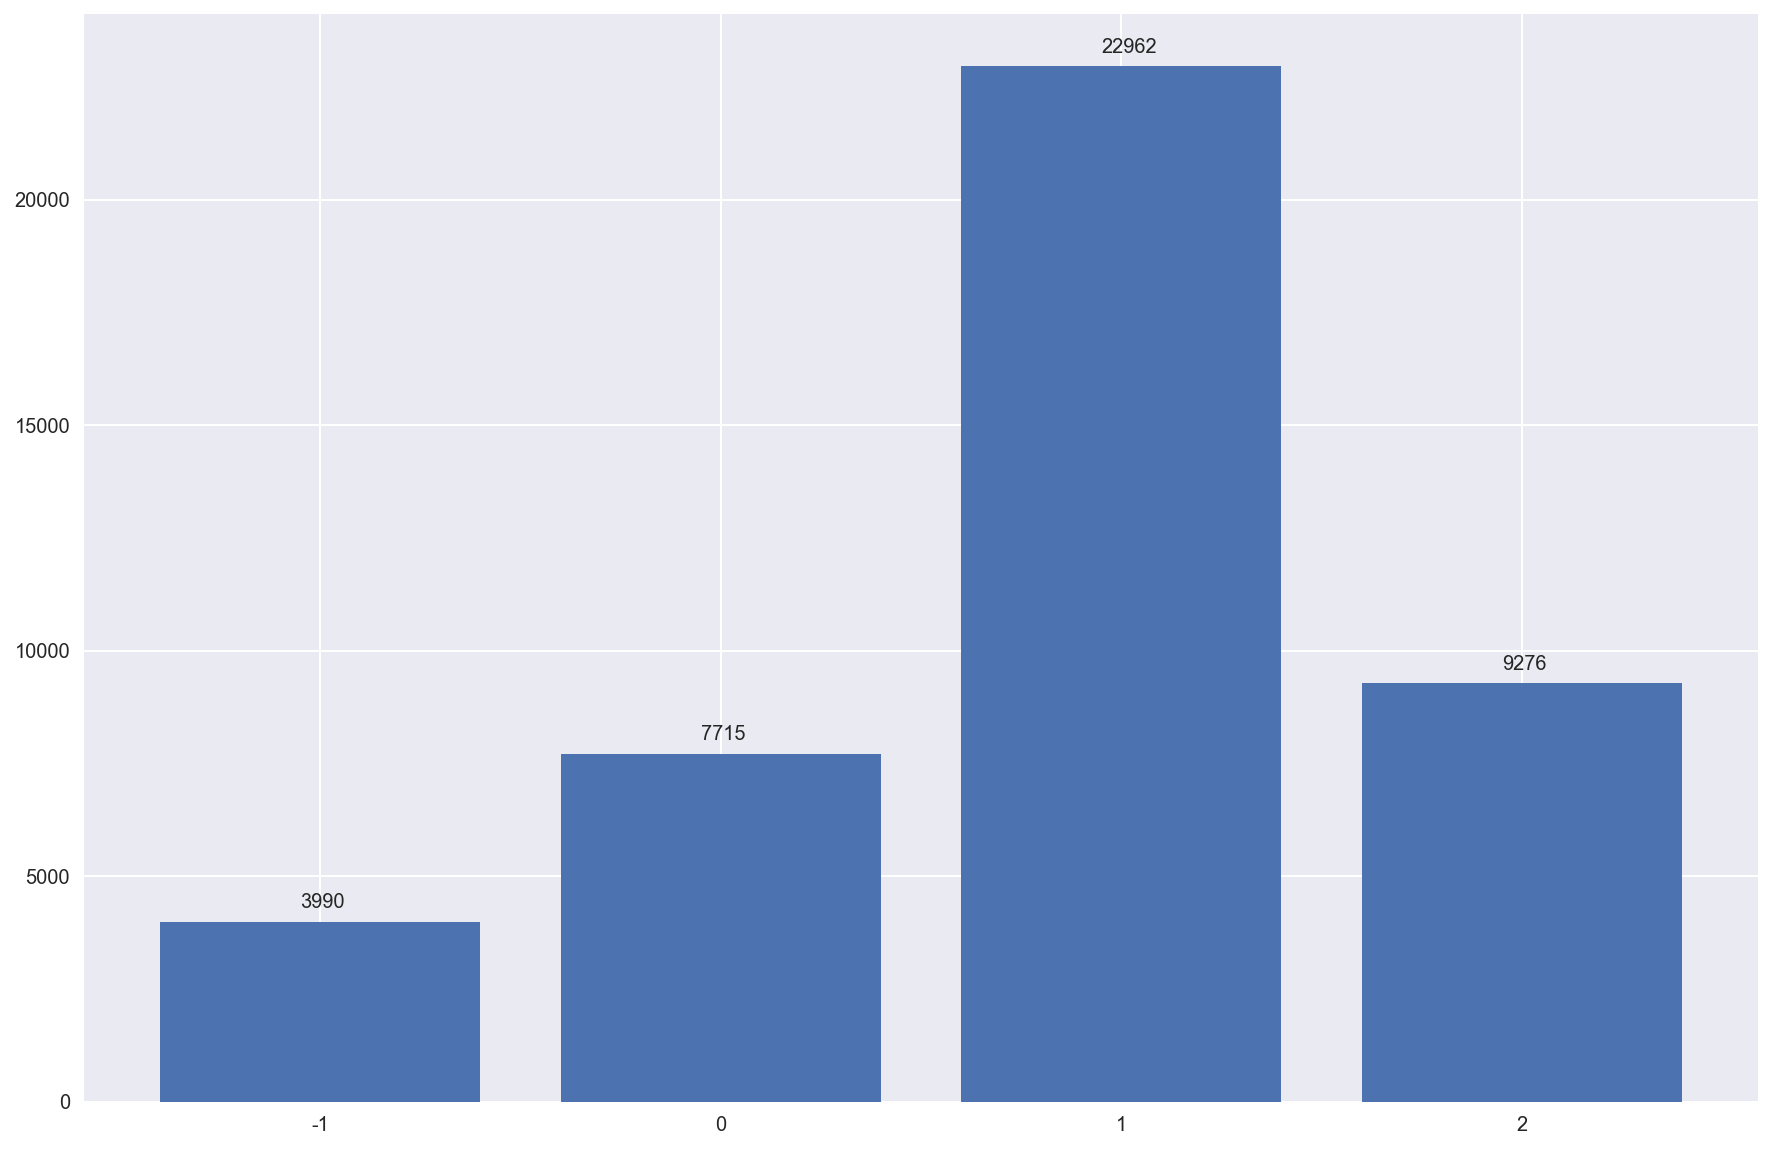

In [16]:
counts = data['sentiment'].value_counts().sort_index().values

plt.bar(range(-1, 3), counts, tick_label=range(-1, 3))

for index, value in enumerate(counts):
    plt.text(index - 1.05, value + 300, str(value))

plt.show()

It looks like our dataset is quite imbalanced: the vast majority of the examples we have express belief in anthropogenic climate change, while a very small minority hold the opposite position, or are neutral. This might have some severe effects on machine learning models we might want to train with it.

## Machine learning with text

Let's explore that idea by training a simple natural language processing (NLP) model to predict whether a message text holds either belief. 

We'll stick with some straightforward principles: first, we'll treat each message as a bag of words, that is we will ignore the order and structure of words, and just count how many times each appears. Second, we'll use a Decision Tree model to make decisions about what belief each message demonstrates, given the words that appear in it.

Let's go ahead and prepare our training and test data by including only messages annotated with either 1 or -1, then converting each message text to a list of word counts.

In [17]:
df = data.loc[(data.sentiment == 1) | (data.sentiment == -1)]
X = df.message
Y = df.sentiment

print(X.shape)
print(Y.shape)

(26952,)
(26952,)


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(strip_accents='unicode', stop_words='english')
X_counts = count_vect.fit_transform(X)

# Feature matrix shape
X_counts.shape

(26952, 47287)

Now that we have a set of feature vectors and labels, we can go ahead and split that into training and test sets, and train our model.

In [19]:
from sklearn import tree

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_counts, Y, test_size=0.33, random_state=42)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.8890387858347386

An accuracy of nearly 90% looks quite good, right? Well, that number may be giving us the wrong impression. Let's look at some more scoring metrics.

              precision    recall  f1-score   support

          -1       0.63      0.50      0.56      1250
           1       0.92      0.95      0.94      7645

    accuracy                           0.89      8895
   macro avg       0.78      0.73      0.75      8895
weighted avg       0.88      0.89      0.88      8895



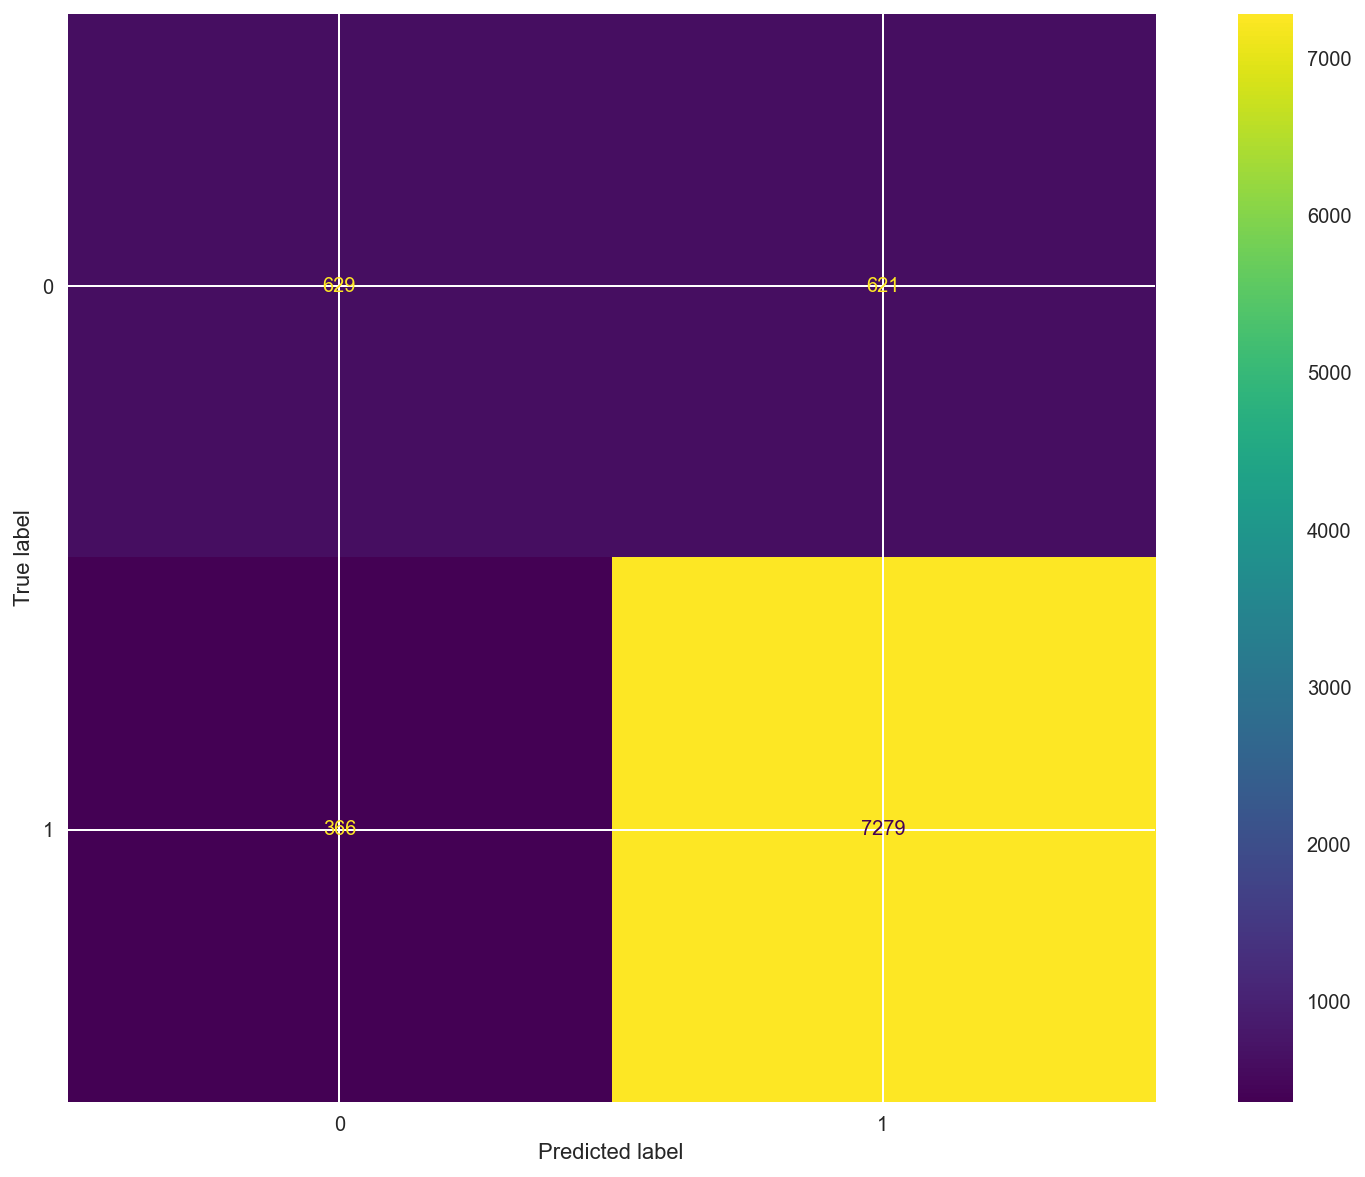

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, preds))

ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()
plt.show()

You can see that the classifier is almost always predicting that the message shows belief in anthropogenic climate change, regardless of what the message content looks like. Because our dataset is so imbalanced, with by far the majority of examples in the positive class, this means that most examples are going to be classified correctly by default, meaning that the accuracy score will be high, regardless of what our model is actually learning.

Using another metric which takes account of the ratio of false predictions as well as true predictions, like F1 or the Matthews Correlation Coefficient, gives us a much clearer understanding of what is going on.

# Ideas for discussion

Here's a set of questions that you might like to think about answering during your DSG challenge. If you don't see anything you're interested in answering, don't worry - feel free to come up with your own problem to solve or interesting piece of data to dig up.

*  Which countries have historically emitted a lot of co2, and what has changed over time?
*  Extrapolate from the cc data to see what potential changes could do to temperature/atmospheric co2?
*  What is the impact of carbon credit trading? Can we see any links with national co2 emissions?
*  What topics do people who believe in human-caused climate change talk about, versus those who don't?
*  Do believers/non-believers form networks - do they retweet each other a lot? You might have to think about linking accounts through matching message texts, or using retweets.
*  Can you predict from a message text whether a person is going to believe in anthropogenic climate change better than the simple model we created? 
*  What about if you disregard named entities, like the UN, IPCC, and so on? What does that do to your models' performance?
* The class imbalance in the text dataset is quite bad, can you determine a way to address this to make machine learning easier to do?

# Presenting your work

The final outcome of your DSG challenge will be a very short presentation to the rest of the groups working alongside you, delivered by your facilitator. We're looking for something that can provide the following:

* An interesting finding for discussion, which you can illustrate with a single slide
* A five minute slot for showing what you've got
* An opportunity for the members of other groups to ask questions and make suggestions, with people from your group able to respond

That last point is important: we want this to be a collaborative experience, so be prepared to both ask and answer questions during the presentation. Remember, this discussion will be between participants, so remain polite, collegial, and constructive at all times.